# <center> Предсказание медицинских расходов граждан США

## <center> Знакомство с данными

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head(2) # charges - целевой признак

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [3]:
data.info() # в таблице нет пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## <center> 1 итерация - бэйслайн, сырые данные

### Исследование данных 

In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


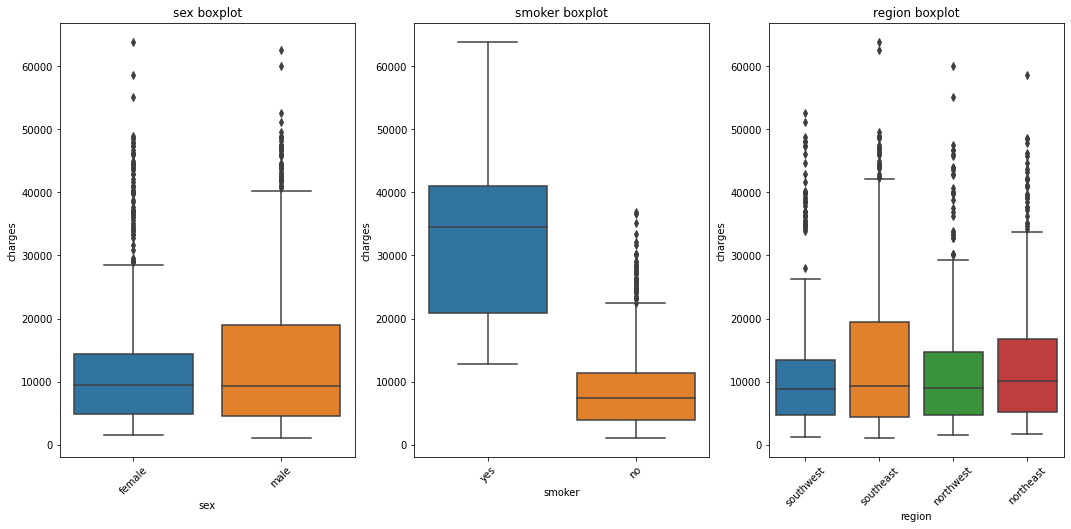

In [6]:
# исследуем категориальные признаки
cat_features = list(data.dtypes[(data.dtypes == 'object')].index)
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for i, feature in enumerate(cat_features): 
    # строим коробчатую диаграмму признака 
    boxplot = sns.boxplot(data=data, x=feature, y='charges', ax=axes[i])
    boxplot.set_title('{} boxplot'.format(feature))
    boxplot.xaxis.set_tick_params(rotation=45)

Медиана расходов у мужчин и женщин совпадает, но у расходов мужчин больший разброс. Курильщики платят значительно больше. Стоимость медицинских услуг меняется в разрезе региона: возможно, регион станет источником ценных признаков.

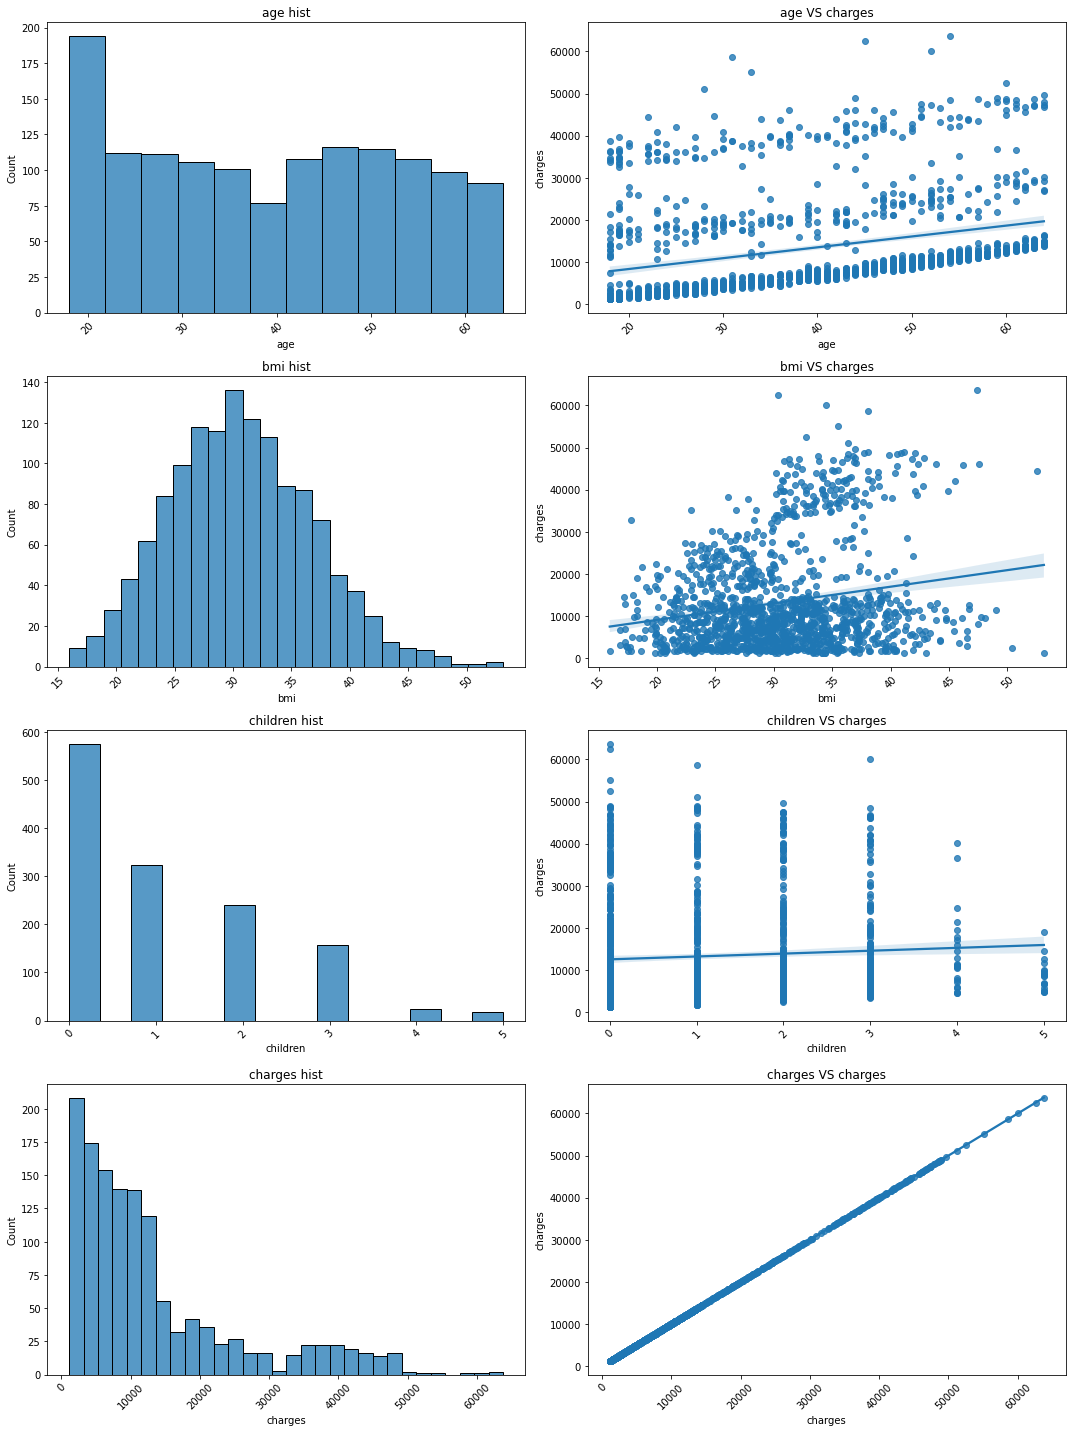

In [7]:
# исследуем числовые признаки
num_features = list(data.dtypes[(data.dtypes != 'object')].index)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for i, feature in enumerate(num_features): 
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=45)

    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    regplot.set_title('{} VS charges'.format(feature))
    regplot.xaxis.set_tick_params(rotation=45)

plt.tight_layout() 

BMI распределен нормально. При BMI около 30 резко возрастает стоимость услуг (это соответствует здравому смыслу: в норме индекс массы тела лежит в пределах от 18.5 до 24.9).
Возможно, целевая переменная распределена логнормально

В остальном, выводы делать сложно. 

### Подготовка данных

In [8]:
# кодируем категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
data = pd.get_dummies(data)

data.head(2)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,16884.9240,0,0,0,1
1,18,1,33.77,1,0,1725.5523,0,0,1,0


In [9]:
# разделяем признаки и целевую переменную
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

# разделяем трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Моделирование

In [10]:
# функция для вывода метрик модели и их визуализации (на трейне и тесте)
def display_metrics(y_train, y_train_predict, y_test, y_test_predict):
    model_metrics = pd.DataFrame({
        'Metric':['R^2', 'MAE', 'MAPE'], 
        'Train':[
            metrics.r2_score(y_train, y_train_predict), 
            round(metrics.mean_absolute_error(y_train, y_train_predict), 2), 
            round(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100, 2)
        ], 
        'Test': [
            metrics.r2_score(y_test, y_test_predict), 
            round(metrics.mean_absolute_error(y_test, y_test_predict), 2), 
            round(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100, 2)
        ]
    })
    model_metrics = model_metrics.set_index('Metric')
    display(model_metrics)

    fig, ax = plt.subplots(figsize=(12, 6)) 
    predict_df = pd.DataFrame({
        'Train errors': y_train - y_train_predict, 
        'Test errors': y_test - y_test_predict
    })
    sns.boxplot(data=predict_df, ax=ax)
    ax.set_xlabel('Model errors') 
    ax.set_ylabel('Model'); 

,Train,Test
Metric,,
R^2,0.741726,0.783593
MAE,4208.230000,4181.190000
MAPE,42.200000,46.890000


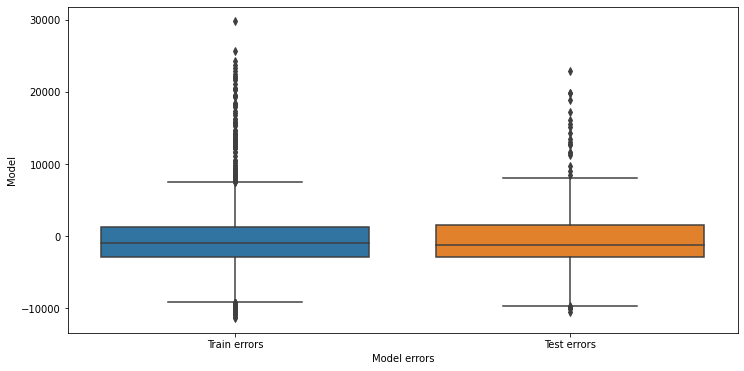

In [11]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
display_metrics(y_train, lr.predict(X_train), y_test, lr.predict(X_test))

### Оценка модели

Медиана ошибок ниже нуля и на трейне, и на тесте (прогноз завышается). В обоих случаях разброс примерно одинаковый. Возможно, в данных есть выбросы. Текущая модель плохо справляется с задачей (MAPE > 40%).

## <center> 2 итерация - log, удаление выбросов

### Гипотеза

Предположение - качество модели повысится, если:
* Перевести целевой признак из логнормального распределения в нормальное с помощью логарифмирования 
* Найти выбросы методом трех сигм и удалить их 
* Добавить признак BMI > 30 (НЕ помогло, пока что убираем этот признак)

### Исследование данных 

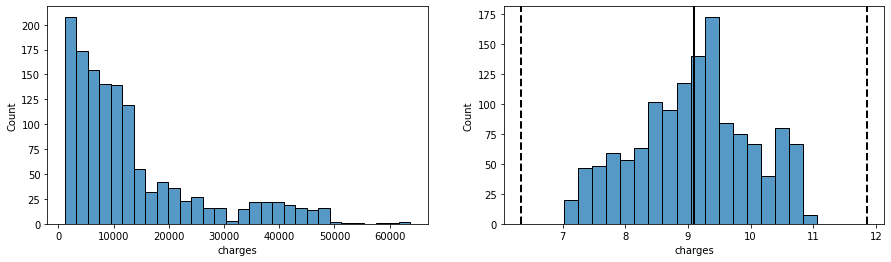

In [12]:
# исследуем распределение charges
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) 
sns.histplot(data=data, x='charges', ax=axes[0]);
log_price = np.log(data['charges'])
sns.histplot(data=log_price, ax=axes[1]);

#Добавляем вертикальные линии для среднего и трех сигм влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Гипотеза подтвердилась: целевой признак распределен логнормально. Выбросы обнаружить не удалось

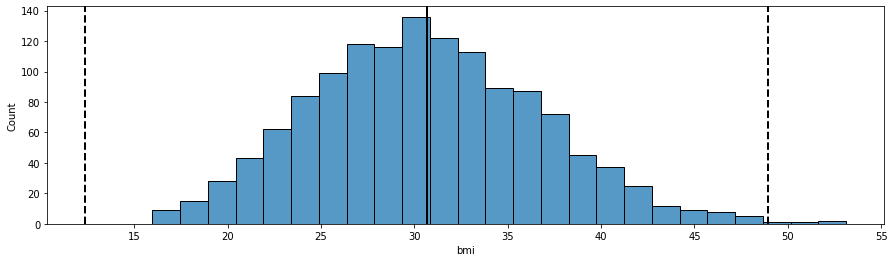

In [13]:
# исследуем распределение bmi
fig, ax = plt.subplots(1, 1, figsize=(15, 4)) 
sns.histplot(data=data, x='bmi', ax=ax);

#Добавляем вертикальные линии для среднего и трех сигм влево и вправо от среднего
ax.axvline(data['bmi'].mean(), color='k', lw=2)
ax.axvline(data['bmi'].mean()+ 3 *data['bmi'].std(),
                color='k', ls='--', lw=2)
ax.axvline(data['bmi'].mean()- 3 *data['bmi'].std(),
                color='k', ls='--', lw=2);

Обнаружены выбросы в районе bmi = 49

### Подготовка данных 

In [14]:
# удалим выбросы
print(data.shape[0]) 
data = data[data['bmi'] < data['bmi'].mean() + 3*data['bmi'].std()]
print(data.shape[0]) # выбросов всего 4, их можно удалить

1338
1334


In [15]:
# принак, что bmi>30, ухудшил качество модели. Убираем
# data['bmi>30'] = data['bmi'].apply(lambda x: 1 if x>30 else 0)
# data.head(2)

In [16]:
# разделяем признаки и целевую переменную
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

# разделяем трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# логарифмируем целевую переменную, не забудем в конце вернуть предсказание в изначальный вид
y_train_log = np.log(y_train)

### Моделирование

,Train,Test
Metric,,
R^2,0.492355,0.600697
MAE,4253.860000,4150.810000
MAPE,26.390000,26.560000


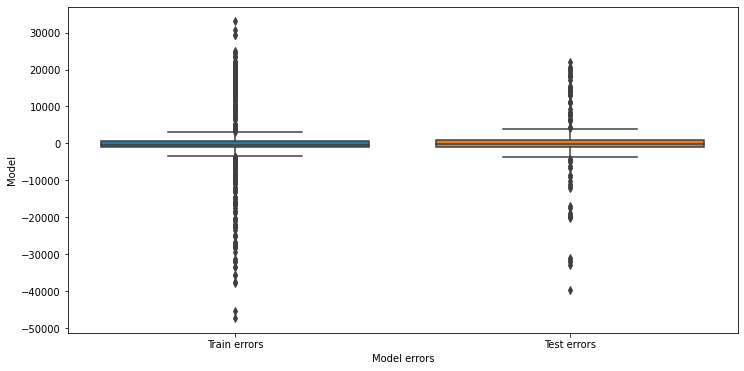

In [17]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)
y_train_predict, y_test_predict = np.exp(lr.predict(X_train)), np.exp(lr.predict(X_test))
display_metrics(y_train, y_train_predict, y_test, y_test_predict) # не забываем, что модель натренирована на логарифм целевой переменной

In [18]:
print(lr.intercept_, lr.coef_)

6.948727231344849 [ 0.03443761 -0.0910669   0.01343779  0.10447659  1.56175426  0.09219291
  0.03459299 -0.08289476 -0.04389115]


### Оценка модели

К сожалению, R^2 на трейне и тесте упал с 0.74 и 0.78 до 0.49 и 0.60 соответственно.
MAE немного упала, но, в целом, осталась на уровне 4200 на трейне и тесте.

Однко, MAPE упала с 42.20 до 26.39 на тесте и с 46.89 до 26.56 на трейне, это почти двукратное улучшение

Судя по величине весов, у модели может быть небольшое переобучение

## <center> 3 итерация - нормализация, полином

### Гипотеза

Предположение - качество модели повысится, если:
* Нормализовать признаки
* Добавить полиномиальную модель

### Подготовка данных

In [19]:
# MinMax нормализация
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# добавляем признаки степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

### Моделирование

,Train,Test
Metric,,
R^2,0.842019,0.86094
MAE,2804.220000,2981.66000
MAPE,27.650000,29.53000


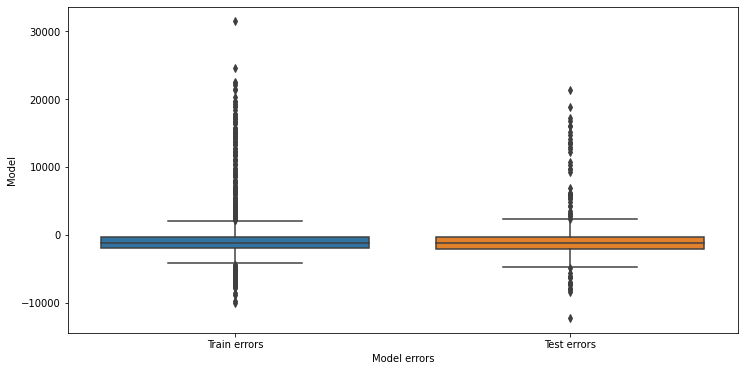

In [21]:
# полиномиальная модель
lr_scaled_poly = linear_model.LinearRegression()
lr_scaled_poly.fit(X_train_scaled_poly, y_train)
display_metrics(y_train, lr_scaled_poly.predict(X_train_scaled_poly), y_test, lr_scaled_poly.predict(X_test_scaled_poly))

In [22]:
print(lr_scaled_poly.intercept_, lr_scaled_poly.coef_)

-8908779423486901.0 [-1.28566764e+17  4.75980255e+16 -2.48908897e+16 -5.23547105e+16
 -4.50270135e+14  1.23809270e+16  1.40204519e+16  6.53944237e+15
 -3.56938084e+15  1.02720000e+04  6.40000000e+01  5.76000000e+02
 -1.37600000e+03 -1.14400000e+03  1.28566764e+17  1.28566764e+17
  1.28566764e+17  1.28566764e+17 -7.01477186e+15  3.06000000e+02
 -9.14000000e+02 -9.95000000e+01 -4.05832537e+16 -4.05832537e+16
 -4.05832537e+16 -4.05832537e+16 -3.12050000e+03  2.21562500e+02
  5.01802500e+04  2.48908897e+16  2.48908897e+16  2.48908897e+16
  2.48908897e+16 -3.37400000e+03 -2.23200000e+03  5.23547105e+16
  5.23547105e+16  5.23547105e+16  5.23547105e+16 -2.70062537e+15
  3.15089551e+15  3.15089551e+15  3.15089551e+15  3.15089551e+15
 -3.47214754e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.11167251e+15  0.00000000e+00  0.00000000e+00  2.36933705e+15
  0.00000000e+00  1.24781603e+16]


,Train,Test
Metric,,
R^2,0.819375,0.809221
MAE,2571.030000,2882.860000
MAPE,17.120000,18.850000


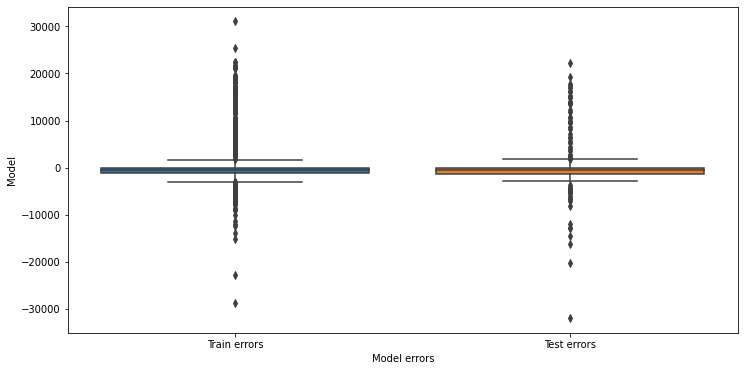

In [23]:
# полиномиальная модель, настроенная на логарифм целевой переменной
lr_scaled_poly.fit(X_train_scaled_poly, y_train_log)
y_train_predict, y_test_predict = np.exp(lr_scaled_poly.predict(X_train_scaled_poly)), np.exp(lr_scaled_poly.predict(X_test_scaled_poly))
display_metrics(y_train, y_train_predict, y_test, y_test_predict)

In [24]:
print(lr_scaled_poly.intercept_, lr_scaled_poly.coef_)

-842250671219.3324 [-6.83289963e+12  3.82552788e+12 -1.08164462e+12 -2.66267462e+12
 -5.25825026e+10  1.03098279e+12  9.45325983e+11  6.78213041e+11
 -2.52389429e+11 -2.23632812e-01  1.72119141e-01 -2.02636719e-01
 -1.04150391e+00 -1.52734375e+00  6.83289963e+12  6.83289963e+12
  6.83289963e+12  6.83289963e+12 -5.45221022e+11  1.10778809e-01
 -9.64355469e-03  8.90197754e-02 -3.28030685e+12 -3.28030685e+12
 -3.28030685e+12 -3.28030685e+12 -3.52935791e-01 -8.26377869e-02
  1.75015259e+00  1.08164462e+12  1.08164462e+12  1.08164462e+12
  1.08164462e+12 -4.72900391e-01 -6.94091797e-01  2.66267462e+12
  2.66267462e+12  2.66267462e+12  2.66267462e+12 -1.84328659e+11
  2.36911162e+11  2.36911162e+11  2.36911162e+11  2.36911162e+11
 -1.88732114e+11  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.03075311e+11  0.00000000e+00  0.00000000e+00  1.64037630e+11
  0.00000000e+00  1.09464010e+12]


### Оценка моделей

Первая модель (полином + логнормальное распределение целевой переменной) уже показала улучшение всех метрик.
Вторая модель практически совпала с первой по R^2, но показала значительные улучшения по MAE и MAPE. Далее все-таки будем использовать ее.

Обе модели сильно переобучены, судя по величине коэффициентов.

## <center> 4 итерация - регуляризация

### Гипотеза

Предположение - качество модели повысится, если:
* Добавить L1 (Lasso) или L2 (Ridge) регуляризатор

### Моделирование

,Train,Test
Metric,,
R^2,-0.126317,-0.149819
MAE,8215.620000,8876.800000
MAPE,96.660000,96.660000


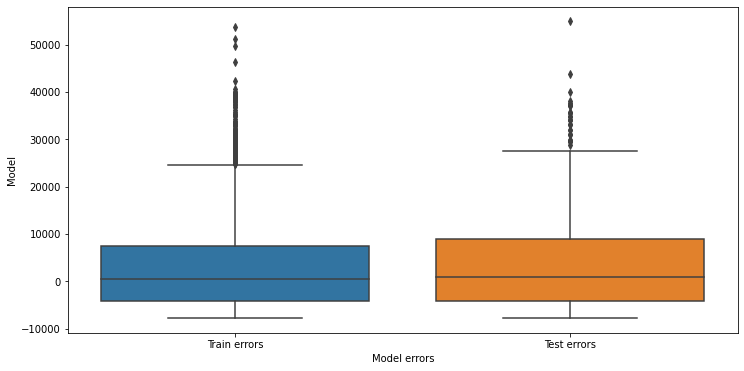

In [25]:
# L1-регуляризатор (по модулям)
lr_lasso = linear_model.Lasso()
lr_lasso.fit(X_train_scaled_poly, y_train_log)
y_train_predict, y_test_predict = np.exp(lr_lasso.predict(X_train_scaled_poly)), np.exp(lr_lasso.predict(X_test_scaled_poly))
display_metrics(y_train, y_train_predict, y_test, y_test_predict)

,Train,Test
Metric,,
R^2,0.820586,0.840938
MAE,2572.370000,2699.420000
MAPE,17.360000,18.790000


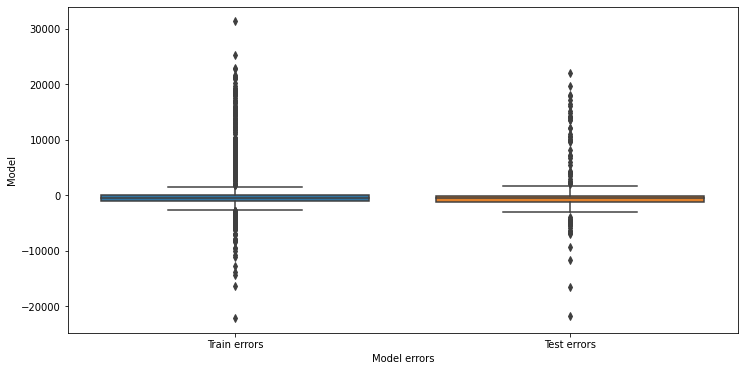

In [26]:
# L2-регуляризатор (по квадратам)
lr_ridge = linear_model.Ridge()
lr_ridge.fit(X_train_scaled_poly, y_train_log)
y_train_predict, y_test_predict = np.exp(lr_ridge.predict(X_train_scaled_poly)), np.exp(lr_ridge.predict(X_test_scaled_poly))
display_metrics(y_train, y_train_predict, y_test, y_test_predict)

### Оценка моделей

L1-регуляритатор ухудшил качество модели.

L2-регуляризатор почти не повлиял на качество модели, но думаю, что в итоговую модель его стоит добавить, чтобы обезопаситься от переобучения

## <center> Итог

In [27]:
baseline_metrics = pd.DataFrame({
    'Metric': ['R^2','MAE','MAPE'],
    'Train':[0.741726, 4208.23, 42.20],
    'Test': [0.783593, 4181.19, 46.89]
})
baseline_metrics = baseline_metrics.set_index('Metric')

final_metrics = pd.DataFrame({
    'Metric': ['R^2','MAE','MAPE'],
    'Train':[0.820586, 2572.37, 17.36],
    'Test': [0.840938, 2699.42, 18.79]
})
final_metrics = final_metrics.set_index('Metric')

improvement_abs = final_metrics-baseline_metrics
improvement_abs = improvement_abs.rename(columns={"Train": "Train_abs_change", "Test": "Test_abs_change"}, errors="raise")
improvement_pct = 100*(final_metrics-baseline_metrics) / baseline_metrics
improvement_pct = improvement_pct.rename(columns={"Train": "Train_%_change", "Test": "Test_%_change"}, errors="raise")
improvement = pd.concat([improvement_abs, improvement_pct], axis = 1)
display(improvement)

,Train_abs_change,Test_abs_change,Train_%_change,Test_%_change
Metric,,,,
R^2,0.07886,0.057345,10.631958,7.318212
MAE,-1635.86000,-1481.770000,-38.872875,-35.438954
MAPE,-24.84000,-28.100000,-58.862559,-59.927490


Модель позволила уменьшить величину средней абсолютной процентной ошибки (MAPE) более чем вдвое: почти на 60%. Средняя абсолютная ошибка уменьшилась на полторы тысячи долларов. R^2 улучшился примерно на 10 пунктов.